# FT-Transformer

## Setting

In [ ]:
# rtdl: ResNet, FT-Transformer
!pip install rtdl
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
import rtdl
from typing import Any, Dict

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
# device check
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


In [ ]:
def seed_everything(seed = 21):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
def read_split_data():
    df = pd.read_csv('/content/drive/MyDrive/Data/adult.csv')
    X = {}
    y = {}
    X['train'], X['test'], y['train'], y['test'] = train_test_split(df.iloc[:, :-1], df.income, test_size = 0.10, random_state=21)
    X['train'], X['val'], y['train'], y['val'] = train_test_split(X['train'], y['train'], test_size = 0.10, random_state=21)

    return X, y

In [ ]:
def preprocessing(X, y):
    cat_index = X['train'].select_dtypes(['object']).columns
    num_index = X['train'].select_dtypes(['int64']).columns

    # categorical cardinalities for CategoricalFeatureTokenizer
    cat_cardinalities = []

    # StandardScaler
    ss = StandardScaler()
    X['train'][num_index] = ss.fit_transform(X['train'][num_index])
    X['val'][num_index] = ss.transform(X['val'][num_index])
    X['test'][num_index] = ss.transform(X['test'][num_index])
    # float64 -> float32 (recommended)
    X['train'][num_index] = X['train'][num_index].apply(lambda x: x.astype('float32'))
    X['val'][num_index] = X['val'][num_index].apply(lambda x: x.astype('float32'))
    X['test'][num_index] = X['test'][num_index].apply(lambda x: x.astype('float32'))

    # LabelEncoder
    for col in cat_index:
      le = LabelEncoder()

      X['train'][col] = le.fit_transform(X['train'][col])

      # X_val, X_test에만 존재하는 label이 있을 경우
      for label in np.unique(X['val'][col]):
        if label not in le.classes_:
          le.classes_ = np.append(le.classes_, label)

      for label in np.unique(X['test'][col]):
        if label not in le.classes_:
          le.classes_ = np.append(le.classes_, label)

      X['val'][col] = le.transform(X['val'][col])
      X['test'][col] = le.transform(X['test'][col])

      # cardinalities
      max_cat = np.max([np.max(X['train'][col]),
                        np.max(X['val'][col]),
                        np.max(X['test'][col])]) + 1
      cat_cardinalities.append(max_cat)

   # y = 1 if > 50K
    y['train'] = np.where(y['train']=='>50K', 1, 0).reshape(-1, 1)
    y['val'] = np.where(y['val']=='>50K', 1, 0).reshape(-1, 1)
    y['test'] = np.where(y['test']=='>50K', 1, 0).reshape(-1, 1)

    return X, y, cat_cardinalities

In [ ]:
def setting_rtdl(data, label):
    '''
    DataFrame, np.array -> torch.Tensor
    FT-Transformer: split X -> X_num, X_cat
    '''
    cat_index = data['train'].select_dtypes(['int64']).columns
    num_index = data['train'].select_dtypes(['float32']).columns

    X = {'train': {},
         'val': {},
         'test': {}}
    y = {'train': {},
         'val': {},
         'test': {}}

    X['train']['num'] = torch.tensor(data['train'][num_index].values, device=device)
    X['train']['cat'] = torch.tensor(data['train'][cat_index].values, device=device)

    X['val']['num'] = torch.tensor(data['val'][num_index].values, device=device)
    X['val']['cat'] = torch.tensor(data['val'][cat_index].values, device=device)

    X['test']['num'] = torch.tensor(data['test'][num_index].values, device=device)
    X['test']['cat'] = torch.tensor(data['test'][cat_index].values, device=device)

    # dtype=float for BCELoss
    y['train'] = torch.tensor(label['train'], dtype=torch.float, device=device)
    y['val'] = torch.tensor(label['val'], dtype=torch.float, device=device)
    y['test'] = torch.tensor(label['test'], dtype=torch.float, device=device)

    return X, y

In [ ]:
# Dataset with num / cat features (for rtdl)
class TensorData(Dataset):
    def __init__(self, num, cat, label):
        self.num = num
        self.cat = cat
        self.label = label
        self.len = self.label.shape[0]

    def __getitem__(self, index):
        return self.num[index],self.cat[index], self.label[index]

    def __len__(self):
        return self.len

In [ ]:
def model_train(model, data_loader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0
    corr = 0

    # for rtdl
    for x_num, x_cat, label in tqdm(data_loader):
        optimizer.zero_grad()

        x_num, x_cat, label = x_num.to(device), x_cat.to(device), label.to(device)
        output = model(x_num, x_cat)
        output = torch.sigmoid(output)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        pred = output >= torch.FloatTensor([0.5]).to(device)
        corr += pred.eq(label).sum().item()
        running_loss += loss.item() * x_num.size(0)

    if scheduler:
        scheduler.step()

    # Average accuracy & loss
    accuracy = corr / len(data_loader.dataset)
    loss = running_loss / len(data_loader.dataset)
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)

    return loss, accuracy

In [ ]:
def model_evaluate(model, data_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        running_loss = 0
        corr = 0

        for x_num, x_cat, label in data_loader:
            x_num, x_cat, label = x_num.to(device), x_cat.to(device), label.to(device)
            output = model(x_num, x_cat)
            output = torch.sigmoid(output)

            pred = output >= torch.FloatTensor([0.5]).to(device)
            corr += pred.eq(label).sum().item()
            running_loss += criterion(output, label).item() * x_num.size(0)

        accuracy = corr / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        history['val_loss'].append(loss)
        history['val_accuracy'].append(accuracy)

        return loss, accuracy

In [ ]:
def model_tune(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()

    # train_loader
    for x_num, x_cat, label in train_loader:
        optimizer.zero_grad()
        x_num, x_cat, label = x_num.to(device), x_cat.to(device), label.to(device)
        output = model(x_num, x_cat)
        output = torch.sigmoid(output)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

    # val_loader
    model.eval()
    with torch.no_grad():
        running_loss = 0
        corr = 0

        for x_num, x_cat, label in val_loader:
            x_num, x_cat, label = x_num.to(device), x_cat.to(device), label.to(device)
            output = model(x_num, x_cat)
            output = torch.sigmoid(output)
            pred = output >= torch.FloatTensor([0.5]).to(device)
            corr += pred.eq(label).sum().item()
            running_loss += criterion(output, label).item() * x_num.size(0)

        val_accuracy = corr / len(val_loader.dataset)
        val_loss = running_loss / len(val_loader.dataset)

        return val_loss, val_accuracy

In [ ]:
def plot_loss(history):
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('Loss');
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

def plot_acc(history):
    plt.plot(history['train_accuracy'], label='train', marker='o')
    plt.plot(history['val_accuracy'], label='val',  marker='o')
    plt.title('Accuracy per epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()

In [ ]:
def ready_data():
    # data setting
    seed_everything()
    X, y = read_split_data()
    X, y, cardinalities = preprocessing(X, y)
    X, y = setting_rtdl(X, y)

    # dataset, dataloader
    train_data = TensorData(X['train']['num'], X['train']['cat'], y['train'])
    val_data = TensorData(X['val']['num'], X['val']['cat'], y['val'])
    test_data = TensorData(X['test']['num'], X['test']['cat'], y['test'])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

    return X, y, cardinalities, train_loader, val_loader, test_loader

## Run

In [ ]:
X, y, cardinalities, train_loader, val_loader, test_loader = ready_data()

In [ ]:
'''
FT-Transformer

Examples:
        .. testcode::

            x_num = torch.randn(4, 3)
            x_cat = torch.tensor([[0, 1], [1, 0], [0, 2], [1, 1]])

            module = FTTransformer.make_baseline(
                n_num_features=3,
                cat_cardinalities=[2, 3],
                d_token=8,
                n_blocks=2,
                attention_dropout=0.2,
                ffn_d_hidden=6,
                ffn_dropout=0.2,
                residual_dropout=0.0,
                d_out=1,
            )
            x = module(x_num, x_cat)
            assert x.shape == (4, 1)

Args:
            n_num_features: the number of continuous features
            cat_cardinalities: the cardinalities of categorical features (see
                `CategoricalFeatureTokenizer` to learn more about cardinalities)
            d_token: the token size for each feature. Must be a multiple of :code:`n_heads=8`.
            n_blocks: the number of Transformer blocks
            attention_dropout: the dropout for attention blocks (see `MultiheadAttention`).
                Usually, positive values work better (even when the number of features is low).
            ffn_d_hidden: the *input* size for the *second* linear layer in `Transformer.FFN`.
                Note that it can be different from the output size of the first linear
                layer, since activations such as ReGLU or GEGLU change the size of input.
                For example, if :code:`ffn_d_hidden=10` and the activation is ReGLU (which
                is always true for the baseline and default configurations), then the
                output size of the first linear layer will be set to :code:`20`.
            ffn_dropout: the dropout rate after the first linear layer in `Transformer.FFN`.
            residual_dropout: the dropout rate for the output of each residual branch of
                all Transformer blocks.
            d_out: the output size.
'''

In [ ]:
# embedding dimension = 64
# # of transformer layer = 3
ft_t = rtdl.FTTransformer.make_baseline(n_num_features=X['train']['num'].shape[1],
                                        cat_cardinalities=cardinalities,
                                        d_token=64,
                                        n_blocks=3,
                                        attention_dropout=0.2,
                                        ffn_d_hidden=128,
                                        ffn_dropout=0.1,
                                        residual_dropout=0.1,
                                        d_out=1).to(device)
print(ft_t)

FTTransformer(
  (feature_tokenizer): FeatureTokenizer(
    (num_tokenizer): NumericalFeatureTokenizer()
    (cat_tokenizer): CategoricalFeatureTokenizer(
      (embeddings): Embedding(102, 64)
    )
  )
  (cls_token): CLSToken()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=64, out_features=64, bias=True)
          (W_k): Linear(in_features=64, out_features=64, bias=True)
          (W_v): Linear(in_features=64, out_features=64, bias=True)
          (W_out): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (ffn): FFN(
          (linear_first): Linear(in_features=64, out_features=256, bias=True)
          (activation): ReGLU()
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_second): Linear(in_features=128, out_features=64, bias=True)
        )
        (attention_residual_dropout): Dropout

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.AdamW(ft_t.parameters(), lr = 1e-4, weight_decay=1e-5)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}

EPOCHS = 15
max_loss = np.inf

for epoch in range(EPOCHS):
    train_loss, train_acc = model_train(ft_t, train_loader, criterion, optimizer, device, None)
    val_loss, val_acc = model_evaluate(ft_t, val_loader, criterion, device)

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(ft_t.state_dict(), 'FT-Transformer_Best.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|██████████| 1237/1237 [00:22<00:00, 54.66it/s]


[INFO] val_loss has been improved from inf to 0.32339. Save model.
epoch 01, loss: 0.35004, accuracy: 0.84255, val_loss: 0.32339, val_accuracy: 0.85328 



100%|██████████| 1237/1237 [00:21<00:00, 57.09it/s]


[INFO] val_loss has been improved from 0.32339 to 0.31328. Save model.
epoch 02, loss: 0.31587, accuracy: 0.85541, val_loss: 0.31328, val_accuracy: 0.85578 



100%|██████████| 1237/1237 [00:22<00:00, 56.18it/s]


epoch 03, loss: 0.31053, accuracy: 0.85731, val_loss: 0.31567, val_accuracy: 0.85350 



100%|██████████| 1237/1237 [00:20<00:00, 61.07it/s]


[INFO] val_loss has been improved from 0.31328 to 0.31219. Save model.
epoch 04, loss: 0.30757, accuracy: 0.85771, val_loss: 0.31219, val_accuracy: 0.85510 



100%|██████████| 1237/1237 [00:20<00:00, 59.36it/s]


epoch 05, loss: 0.30668, accuracy: 0.85817, val_loss: 0.31452, val_accuracy: 0.85259 



100%|██████████| 1237/1237 [00:21<00:00, 57.74it/s]


[INFO] val_loss has been improved from 0.31219 to 0.31078. Save model.
epoch 06, loss: 0.30395, accuracy: 0.85865, val_loss: 0.31078, val_accuracy: 0.85282 



100%|██████████| 1237/1237 [00:20<00:00, 61.05it/s]


[INFO] val_loss has been improved from 0.31078 to 0.30716. Save model.
epoch 07, loss: 0.30309, accuracy: 0.86006, val_loss: 0.30716, val_accuracy: 0.85623 



100%|██████████| 1237/1237 [00:21<00:00, 56.26it/s]


epoch 08, loss: 0.30146, accuracy: 0.86054, val_loss: 0.31331, val_accuracy: 0.85373 



100%|██████████| 1237/1237 [00:20<00:00, 60.62it/s]


epoch 09, loss: 0.30070, accuracy: 0.86060, val_loss: 0.31066, val_accuracy: 0.85350 



100%|██████████| 1237/1237 [00:21<00:00, 58.79it/s]


epoch 10, loss: 0.29902, accuracy: 0.86196, val_loss: 0.30841, val_accuracy: 0.85464 



100%|██████████| 1237/1237 [00:21<00:00, 58.50it/s]


epoch 11, loss: 0.29855, accuracy: 0.86118, val_loss: 0.30799, val_accuracy: 0.85623 



100%|██████████| 1237/1237 [00:20<00:00, 60.87it/s]


epoch 12, loss: 0.29839, accuracy: 0.86032, val_loss: 0.31615, val_accuracy: 0.85009 



100%|██████████| 1237/1237 [00:22<00:00, 54.48it/s]


epoch 13, loss: 0.29789, accuracy: 0.86115, val_loss: 0.30838, val_accuracy: 0.85441 



100%|██████████| 1237/1237 [00:20<00:00, 59.77it/s]


epoch 14, loss: 0.29670, accuracy: 0.86171, val_loss: 0.31641, val_accuracy: 0.85350 



100%|██████████| 1237/1237 [00:21<00:00, 56.64it/s]


epoch 15, loss: 0.29638, accuracy: 0.86183, val_loss: 0.31503, val_accuracy: 0.85373 



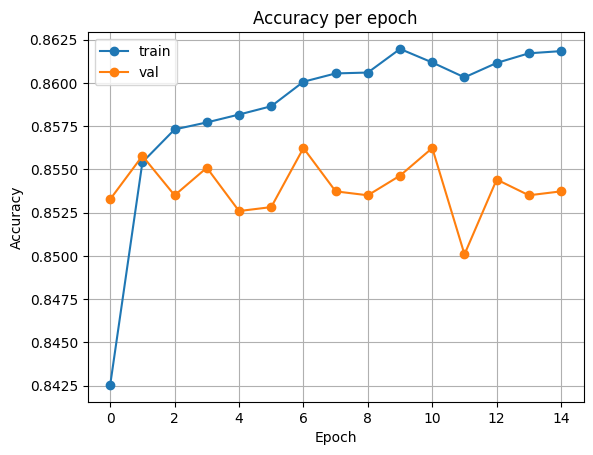

In [ ]:
plot_acc(history)

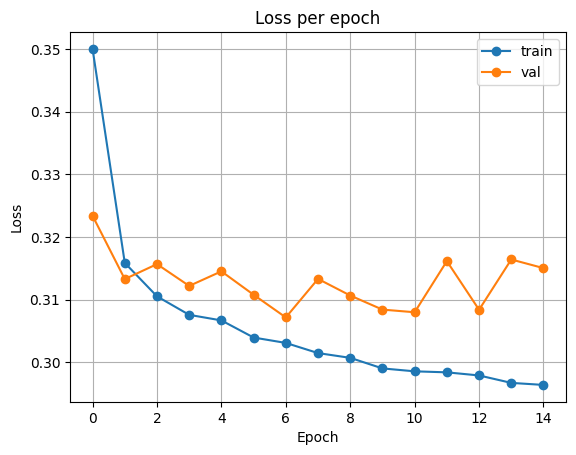

In [ ]:
plot_loss(history)

In [ ]:
# test evaluate
ft_t.load_state_dict(torch.load('FT-Transformer_Best.pth'))
test_loss, test_acc = model_evaluate(ft_t, test_loader, criterion, device)
print('Test loss:', test_loss, '\nTest acc:', test_acc)

Test loss: 0.30666763982606887 
Test acc: 0.8550665301944729


## Tuning

In [ ]:
X, y, cardinalities, train_loader, val_loader, test_loader = ready_data()

In [ ]:
# optuna objective
# hyperparameter space from Revisiting Deep Learning Models for Tabular Data
# suggest_uniform, suggest_loguniform -> suggest_float, suggest_float(log=True)
def objective(trial, train_loader, val_loader):
    d_token = trial.suggest_categorical('d_token', [64, 128, 256, 512])
    n_blocks = trial.suggest_int('n_blocks', 1, 4, log=True)
    attention_dropout = trial.suggest_float('attention_dropout', 0, 0.5)
    ffn_d_hidden = trial.suggest_int('ffn_d_hidden', 64, 1028)
    ffn_dropout = trial.suggest_float('ffn_dropout', 0, 0.5)
    residual_dropout = trial.suggest_float('residual_dropout', 0, 0.2)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weigth_decay', 1e-6, 1e-3, log=True)

    model = rtdl.FTTransformer.make_baseline(n_num_features=X['train']['num'].shape[1],
                                             cat_cardinalities=cardinalities,
                                             d_token=d_token,
                                             n_blocks=n_blocks,
                                             attention_dropout=attention_dropout,
                                             ffn_d_hidden=ffn_d_hidden,
                                             ffn_dropout=ffn_dropout,
                                             residual_dropout=residual_dropout,
                                             d_out=1).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    EPOCHS = 10
    min_loss = np.inf

    for epoch in range(EPOCHS):
        val_loss, val_acc = model_tune(model, train_loader, val_loader, criterion, optimizer, device)

        if val_loss < min_loss:
            min_loss = val_loss

    # minimize minimun loss
    return min_loss

In [ ]:
study = optuna.create_study(study_name='FT-Transformer', direction='minimize', sampler=TPESampler(seed=21))
study.optimize(lambda trial: objective(trial, train_loader, val_loader), n_trials=15)

print()
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-09-03 15:10:26,769] A new study created in memory with name: FT-Transformer
[I 2023-09-03 15:12:01,746] Trial 0 finished with value: 0.31191023896779657 and parameters: {'d_token': 256, 'n_blocks': 1, 'attention_dropout': 0.0253866283476884, 'ffn_d_hidden': 355, 'ffn_dropout': 0.33195514731235, 'residual_dropout': 0.06162287864737577, 'lr': 0.0005633442017222582, 'weigth_decay': 1.6170105887878455e-06}. Best is trial 0 with value: 0.31191023896779657.
[I 2023-09-03 15:15:21,720] Trial 1 finished with value: 0.30791561366537684 and parameters: {'d_token': 64, 'n_blocks': 3, 'attention_dropout': 0.37947191775605715, 'ffn_d_hidden': 1000, 'ffn_dropout': 0.3796512763927764, 'residual_dropout': 0.07685000641802589, 'lr': 0.00016832746705566732, 'weigth_decay': 0.00013806426449912442}. Best is trial 1 with value: 0.30791561366537684.
[I 2023-09-03 15:17:49,153] Trial 2 finished with value: 0.30841183575638 and parameters: {'d_token': 256, 'n_blocks': 2, 'attention_dropout': 0.0839178


Best Score: 0.30758440882320076
Best trial: {'d_token': 64, 'n_blocks': 4, 'attention_dropout': 0.47110354044768354, 'ffn_d_hidden': 111, 'ffn_dropout': 0.4536617774026742, 'residual_dropout': 0.0112958582072534, 'lr': 7.878491237694348e-05, 'weigth_decay': 0.000969774237597253}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
study.best_trial.params

{'d_token': 64,
 'n_blocks': 4,
 'attention_dropout': 0.47110354044768354,
 'ffn_d_hidden': 111,
 'ffn_dropout': 0.4536617774026742,
 'residual_dropout': 0.0112958582072534,
 'lr': 7.878491237694348e-05,
 'weigth_decay': 0.000969774237597253}

In [ ]:
X, y, cardinalities, train_loader, val_loader, test_loader = ready_data()

ft_t = rtdl.FTTransformer.make_baseline(n_num_features=X['train']['num'].shape[1],
                                        cat_cardinalities=cardinalities,
                                        d_token=study.best_trial.params['d_token'],
                                        n_blocks=study.best_trial.params['n_blocks'],
                                        attention_dropout=study.best_trial.params['attention_dropout'],
                                        ffn_d_hidden=study.best_trial.params['ffn_d_hidden'],
                                        ffn_dropout=study.best_trial.params['ffn_dropout'],
                                        residual_dropout=study.best_trial.params['residual_dropout'],
                                        d_out=1).to(device)

criterion = nn.BCELoss()
optimizer = optim.AdamW(ft_t.parameters(),
                        lr = study.best_trial.params['lr'],
                        weight_decay=study.best_trial.params['weigth_decay'])

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}

EPOCHS = 15
max_loss = np.inf

for epoch in range(EPOCHS):
    train_loss, train_acc = model_train(ft_t, train_loader, criterion, optimizer, device, None)
    val_loss, val_acc = model_evaluate(ft_t, val_loader, criterion, device)

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(ft_t.state_dict(), 'FT-Transformer_Best_tuned.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|██████████| 1237/1237 [00:26<00:00, 46.50it/s]


[INFO] val_loss has been improved from inf to 0.32704. Save model.
epoch 01, loss: 0.37064, accuracy: 0.83347, val_loss: 0.32704, val_accuracy: 0.84964 



100%|██████████| 1237/1237 [00:26<00:00, 46.84it/s]


[INFO] val_loss has been improved from 0.32704 to 0.32234. Save model.
epoch 02, loss: 0.32431, accuracy: 0.85213, val_loss: 0.32234, val_accuracy: 0.84964 



100%|██████████| 1237/1237 [00:27<00:00, 44.98it/s]


[INFO] val_loss has been improved from 0.32234 to 0.31594. Save model.
epoch 03, loss: 0.31692, accuracy: 0.85309, val_loss: 0.31594, val_accuracy: 0.85214 



100%|██████████| 1237/1237 [00:27<00:00, 44.25it/s]


epoch 04, loss: 0.31211, accuracy: 0.85544, val_loss: 0.31876, val_accuracy: 0.85191 



100%|██████████| 1237/1237 [00:27<00:00, 44.45it/s]


epoch 05, loss: 0.30868, accuracy: 0.85582, val_loss: 0.32563, val_accuracy: 0.84759 



100%|██████████| 1237/1237 [00:27<00:00, 45.37it/s]


epoch 06, loss: 0.30714, accuracy: 0.85784, val_loss: 0.31656, val_accuracy: 0.85168 



100%|██████████| 1237/1237 [00:27<00:00, 44.86it/s]


epoch 07, loss: 0.30630, accuracy: 0.85918, val_loss: 0.31977, val_accuracy: 0.84827 



100%|██████████| 1237/1237 [00:26<00:00, 46.34it/s]


[INFO] val_loss has been improved from 0.31594 to 0.31213. Save model.
epoch 08, loss: 0.30602, accuracy: 0.85738, val_loss: 0.31213, val_accuracy: 0.85077 



100%|██████████| 1237/1237 [00:27<00:00, 45.03it/s]


[INFO] val_loss has been improved from 0.31213 to 0.31095. Save model.
epoch 09, loss: 0.30443, accuracy: 0.85860, val_loss: 0.31095, val_accuracy: 0.85168 



100%|██████████| 1237/1237 [00:27<00:00, 44.70it/s]


[INFO] val_loss has been improved from 0.31095 to 0.31038. Save model.
epoch 10, loss: 0.30350, accuracy: 0.85888, val_loss: 0.31038, val_accuracy: 0.85350 



100%|██████████| 1237/1237 [00:27<00:00, 44.66it/s]


[INFO] val_loss has been improved from 0.31038 to 0.30803. Save model.
epoch 11, loss: 0.30243, accuracy: 0.85898, val_loss: 0.30803, val_accuracy: 0.85464 



100%|██████████| 1237/1237 [00:26<00:00, 46.09it/s]


epoch 12, loss: 0.30255, accuracy: 0.85948, val_loss: 0.30838, val_accuracy: 0.85373 



100%|██████████| 1237/1237 [00:26<00:00, 47.42it/s]


epoch 13, loss: 0.30143, accuracy: 0.86080, val_loss: 0.31192, val_accuracy: 0.85464 



100%|██████████| 1237/1237 [00:27<00:00, 44.56it/s]


[INFO] val_loss has been improved from 0.30803 to 0.30650. Save model.
epoch 14, loss: 0.30129, accuracy: 0.85958, val_loss: 0.30650, val_accuracy: 0.85373 



100%|██████████| 1237/1237 [00:27<00:00, 44.42it/s]


epoch 15, loss: 0.30042, accuracy: 0.85961, val_loss: 0.31261, val_accuracy: 0.85487 



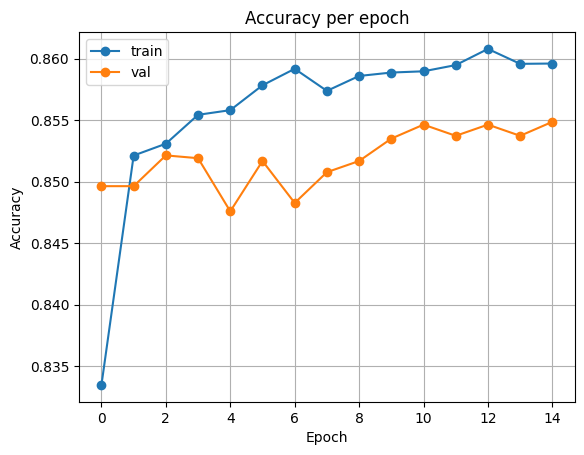

In [ ]:
plot_acc(history)

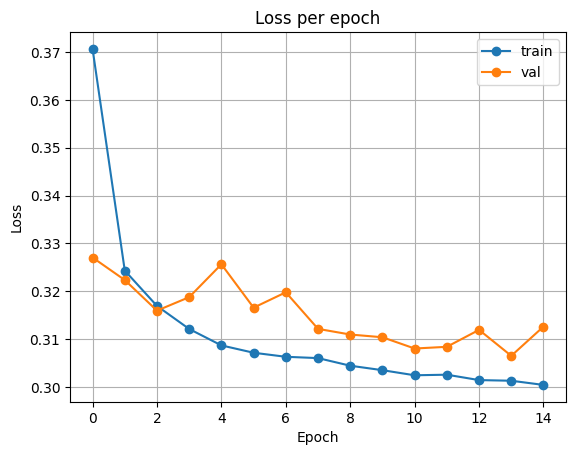

In [ ]:
plot_loss(history)

In [ ]:
# test evaluate
ft_t.load_state_dict(torch.load('FT-Transformer_Best_tuned.pth'))
test_loss, test_acc = model_evaluate(ft_t, test_loader, criterion, device)
print('Test loss:', test_loss, '\nTest acc:', test_acc)

Test loss: 0.3057573468774222 
Test acc: 0.8595701125895598
